<a href="https://colab.research.google.com/github/oodlbee/drug_prediction/blob/bob2708_branch/drug_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit

In [2]:
!pip install catboost

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

In [4]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Предобработка

## Уже обработанное

In [172]:
# full = pd.read_csv("https://raw.githubusercontent.com/oodlbee/drug_prediction/master/processed_df.csv")
full = pd.read_csv("https://raw.githubusercontent.com/oodlbee/drug_prediction/antons_branch/processed_df_without_corr.csv")
full.head(1)

,Unnamed: 0,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,#stars,...,#metab,HumanOralAbsorption,PercentHumanOralAbsorption,SAfluorine,SAamideO,PSA,RuleOfFive,#ringatoms,#in34,#noncon
0,0,1007-Ya-213,2.7,500.0,185.185185,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,2.0,...,2.0,3.0,100.0,0.0,0.0,35.245,0.0,0.0,0.0,0.0


In [173]:
def mol_dsc_calc(mols):
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in mols)

# список конституционных и физико-химических дескрипторов из библиотеки RDKit
descriptors = {"HeavyAtomCount": Descriptors.HeavyAtomCount,
               "NHOHCount": Descriptors.NHOHCount,
               "NOCount": Descriptors.NOCount,
               "NumHAcceptors": Descriptors.NumHAcceptors,
               "NumHDonors": Descriptors.NumHDonors,
               "NumHeteroatoms": Descriptors.NumHeteroatoms,
               "NumRotatableBonds": Descriptors.NumRotatableBonds,
               "NumValenceElectrons": Descriptors.NumValenceElectrons,
               "NumAromaticRings": Descriptors.NumAromaticRings,
               "NumAliphaticHeterocycles": Descriptors.NumAliphaticHeterocycles,
               "RingCount": Descriptors.RingCount,
               "MW": Descriptors.MolWt,
               "LogP": Descriptors.MolLogP,
               "MR": Descriptors.MolMR,
               "TPSA": Descriptors.TPSA}

# sklearn трансформер для использования в конвейерном моделировании
descriptors_transformer = FunctionTransformer(mol_dsc_calc)
processed_smiles = descriptors_transformer.transform(full['SMILES'])
processed_smiles

[18:09:41] Conflicting single bond directions around double bond at index 55.
[18:09:41]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:09:41] Conflicting single bond directions around double bond at index 55.
[18:09:41]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:09:41] Conflicting single bond directions around double bond at index 55.
[18:09:41]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:09:41] Conflicting single bond directions around double bond at index 55.
[18:09:41]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:09:41] Conflicting single bond directions around double bond at index 55.
[18:09:41]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:09:41] Conflicting single bond directions around double bond at index 55.
[18:09:41]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:09:41] Conflicting single bond direc

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,LogP,MR,TPSA
0,14,1,2,2,1,2,2,80,0,0,2,195.306,2.26590,58.6168,32.59
1,18,0,2,2,0,2,5,104,0,0,2,250.430,3.61540,79.3190,15.60
2,16,0,2,2,0,2,3,92,0,0,2,222.376,2.83520,70.0850,15.60
3,17,0,3,3,0,3,3,98,0,0,2,239.359,2.30600,67.6630,29.54
4,41,0,4,2,0,4,16,236,0,0,4,570.995,8.44430,179.0658,24.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,18,0,3,3,0,3,7,102,1,0,1,252.354,3.71572,73.2770,39.44
1313,17,1,3,3,1,3,6,96,1,0,1,238.327,3.41272,68.3898,50.44
1314,17,0,3,3,0,3,6,96,1,0,1,238.327,3.32562,68.6600,39.44
1315,16,0,3,3,0,3,5,90,1,0,1,224.300,2.93552,64.0430,39.44


In [174]:
full.drop(["Title","SMILES","Unnamed: 0"], axis=1, inplace=True)
full = full.join(processed_smiles)
X = full.iloc[:, 3:]
y = full.iloc[:, :3]
y_si = y["SI"]
y_ic = y["IC50, mmg/ml"]
y_cc = y["CC50-MDCK, mmg/ml"]
X_train, X_test, y_train, y_test = train_test_split(X, y_ic,  test_size=0.25, random_state=42)

In [149]:
X

,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,#stars,#amine,#amidine,#acid,#amide,#rotor,...,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,LogP,MR,TPSA
0,195.307,2,1,32.59,2.0,0.0,0.0,0.0,0.0,10.0,...,2,2,80,0,0,2,195.306,2.26590,58.6168,32.59
1,250.431,1,0,15.60,2.0,1.0,0.0,0.0,0.0,12.0,...,2,5,104,0,0,2,250.430,3.61540,79.3190,15.60
2,222.377,1,0,15.60,3.0,1.0,0.0,0.0,0.0,10.0,...,2,3,92,0,0,2,222.376,2.83520,70.0850,15.60
3,239.361,2,0,29.54,1.0,1.0,0.0,0.0,0.0,9.0,...,3,3,98,0,0,2,239.359,2.30600,67.6630,29.54
4,570.997,2,0,24.72,7.0,0.0,0.0,0.0,0.0,30.0,...,4,16,236,0,0,4,570.995,8.44430,179.0658,24.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,252.357,3,0,39.44,1.0,0.0,0.0,0.0,0.0,7.0,...,3,7,102,1,0,1,252.354,3.71572,73.2770,39.44
1313,238.330,3,1,50.44,0.0,0.0,0.0,0.0,0.0,7.0,...,3,6,96,1,0,1,238.327,3.41272,68.3898,50.44
1314,238.330,3,0,39.44,1.0,0.0,0.0,0.0,0.0,6.0,...,3,6,96,1,0,1,238.327,3.32562,68.6600,39.44
1315,224.303,3,0,39.44,1.0,0.0,0.0,0.0,0.0,5.0,...,3,5,90,1,0,1,224.300,2.93552,64.0430,39.44


## Первый лист 1400

In [150]:
# df_1400 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1400.xlsx')
# df_1400.head()

In [151]:
# df_1400.describe()

In [152]:
# df_1400_easy = df_1400.drop(["Title", "Pictures", "SMILES"], axis=1)
# df_1400_easy['SI'] = df_1400_easy['CC50-MDCK, mmg/ml']/df_1400_easy['IC50, mmg/ml']
# df_1400_easy.info()

In [153]:
# X = df_1400_easy.iloc[:, 3:]
# y = df_1400_easy.iloc[:, :3]
# X

In [154]:
# # Варианты целевой колонки
# y_si = y["SI"]
# y_ic = y["IC50, mmg/ml"]
# y_cc = y["CC50-MDCK, mmg/ml"]

In [155]:
# # Не забываем заменить агрумент 'y' при выборе другого целевого столбца
# X_train, X_test, y_train, y_test = train_test_split(X, y_ic,  test_size=0.25, random_state=42)

## Второй лист 1400

In [156]:
# df_1400_big = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1400.xlsx', 1)
# df_1400_big.info()

In [157]:
# df_1400_big = df_1400_big.drop(['molecule', 'Pictures', 'SMILES', 'Unnamed: 55', 'Unnamed: 56'], axis=1)
# df_1400_big.dropna(inplace=True)

In [158]:
# X = df_1400_big.iloc[:, 3:]
# y = df_1400_big.iloc[:, :3]
# y_si = y["SI"]
# y_ic = y["IC50, mmg/ml"]
# y_cc = y["CC50-MDCK, mmg/ml"]

In [159]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_cc,  test_size=0.25, random_state=42)

# Запуск моделей

## Линейная регрессия

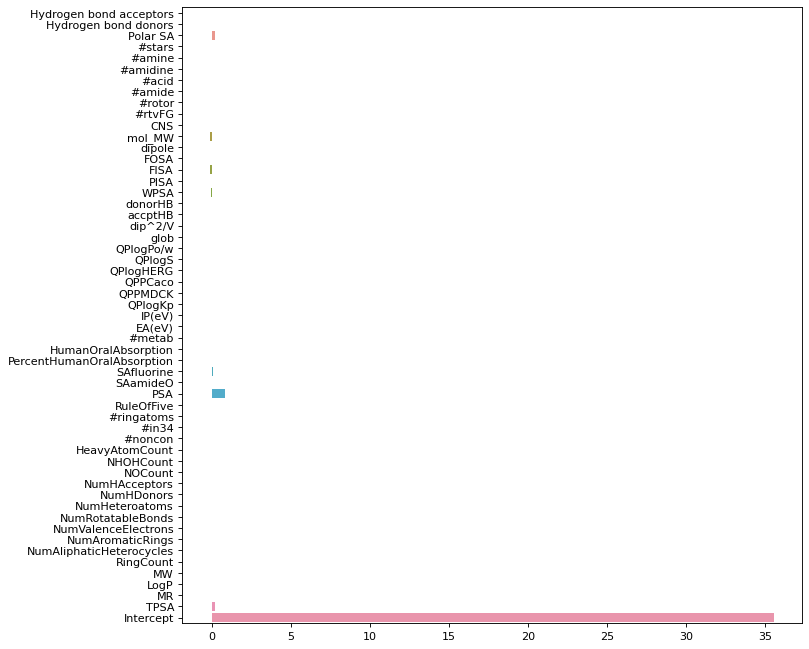

In [175]:
lasso = LassoCV(eps = 0.001, n_alphas = 100, cv = 4, random_state = 13).fit(X_train, y_train)
plt.figure(figsize=(10, 10), dpi=80)
coefs = np.append(lasso.coef_, lasso.intercept_)
names = list(X_train.columns)
names.append('Intercept')
g = sns.barplot(y=names, x=coefs)#, columns=X_train.columns)
plt.show()

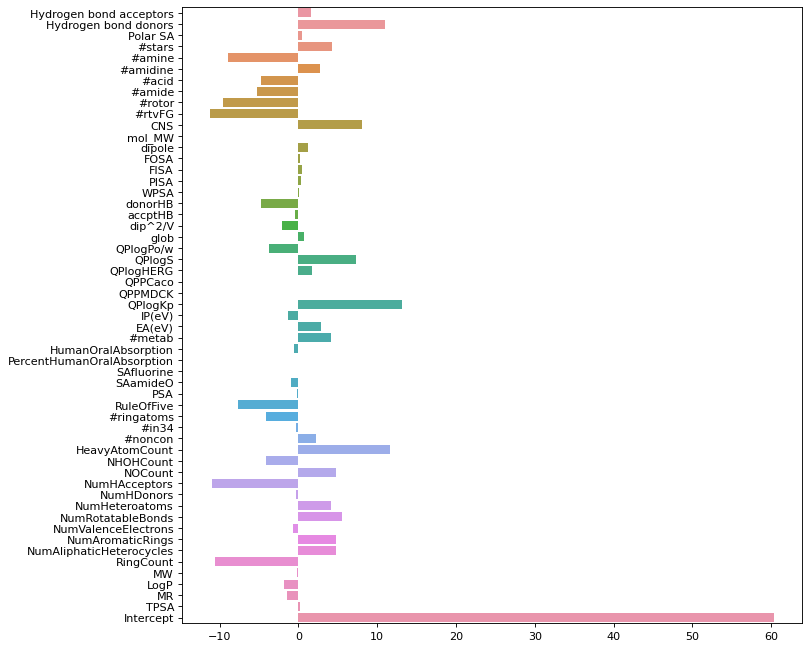

In [176]:
ridge = RidgeCV(alphas = np.linspace(10, 25, 100), cv = 4).fit(X_train, y_train)
plt.figure(figsize=(10, 10), dpi=80)
coefs = np.append(ridge.coef_, ridge.intercept_)
names = list(X_train.columns)
names.append('Intercept')
g = sns.barplot(y=names, x=coefs)#, columns=X_train.columns)
plt.show()

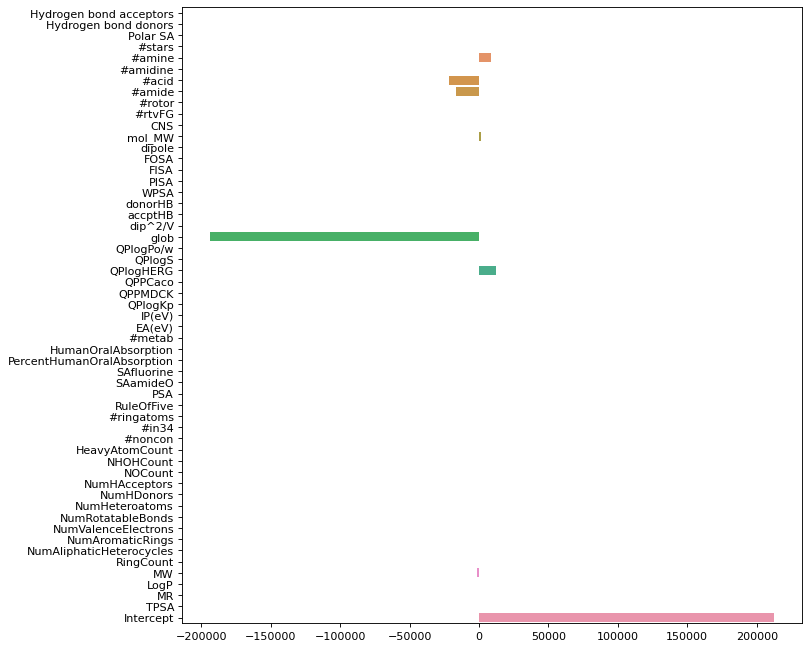

In [177]:
lr = LinearRegression().fit(X_train, y_train)
plt.figure(figsize=(10, 10), dpi=80)
coefs = np.append(lr.coef_, lr.intercept_)
names = list(X_train.columns)
names.append('Intercept')
g = sns.barplot(y=names, x=coefs)#, columns=X_train.columns)
plt.show()

## SVR

In [178]:
line_param = np.linspace(0, 20, 20)
parameters = {'kernel':('rbf', "poly", "sigmoid"), 'C':line_param}
svr = SVR()
grid_search_svm = GridSearchCV(estimator=svr, param_grid=parameters, cv = 6)
grid_search_svm.fit(X_train, y_train)
svr = grid_search_svm.best_estimator_
# svr_nofit = SVR().fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_para

## Деревья (лес)

In [179]:
rf = RandomForestRegressor().fit(X_train, y_train)
rf.score(X_test, y_test)

0.2583955356322186

## Деревья (Бустинг)

In [180]:
ada = AdaBoostRegressor().fit(X_train, y_train)
cat = CatBoostRegressor().fit(X_train, y_train)

Learning rate set to 0.040858
0:	learn: 82.2809270	total: 15.4ms	remaining: 15.4s
1:	learn: 81.6830199	total: 32.7ms	remaining: 16.3s
2:	learn: 81.1386143	total: 47.7ms	remaining: 15.9s
3:	learn: 80.5440442	total: 62.6ms	remaining: 15.6s
4:	learn: 79.8202100	total: 71ms	remaining: 14.1s
5:	learn: 79.4527487	total: 79.7ms	remaining: 13.2s
6:	learn: 78.8112295	total: 88.5ms	remaining: 12.5s
7:	learn: 78.2623977	total: 101ms	remaining: 12.5s
8:	learn: 77.9130994	total: 110ms	remaining: 12.1s
9:	learn: 77.2584538	total: 120ms	remaining: 11.8s
10:	learn: 76.7563420	total: 142ms	remaining: 12.8s
11:	learn: 76.3315640	total: 150ms	remaining: 12.4s
12:	learn: 75.9673291	total: 159ms	remaining: 12.1s
13:	learn: 75.6450507	total: 167ms	remaining: 11.8s
14:	learn: 75.1975122	total: 176ms	remaining: 11.5s
15:	learn: 74.8375355	total: 185ms	remaining: 11.4s
16:	learn: 74.4620447	total: 199ms	remaining: 11.5s
17:	learn: 74.2094891	total: 209ms	remaining: 11.4s
18:	learn: 73.7865269	total: 218ms	rema

# Оценка моделей

In [181]:
def calc_metrics(model, X_test=X_test, y_test=y_test, df=None):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    r2 = model.score(X_test, y_test)
    pred_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, pred_train)
    r2_train = model.score(X_train, y_train)
    if df is not None:
        df.loc[str(model)] = [mae_train, mae, r2_train, r2]
    else:
        print(f"R-score: {r2}\nMAE: {mae}")

In [182]:
models = [lr, ridge, lasso, svr, rf, ada, cat]
metrics = pd.DataFrame(columns=('MAE train', 'MAE test', 'R2 train', 'R2 test'))
for model in models:
    calc_metrics(model, df=metrics)
metrics

,MAE train,MAE test,R2 train,R2 test
LinearRegression(),47.107874,51.077935,0.273611,0.211694
"RidgeCV(alphas=array([10. , 10.15151515, 10.3030303 , 10.45454545, 10.60606061,\n 10.75757576, 10.90909091, 11.06060606, 11.21212121, 11.36363636,\n 11.51515152, 11.66666667, 11.81818182, 11.96969697, 12.12121212,\n 12.27272727, 12.42424242, 12.57575758, 12.72727273, 12.87878788,\n 13.03030303, 13.18181818, 13.33333333, 13.48484848, 13.63636364,\n 13.78787879, 13.93939394, 14.09090909, 1...\n 20.60606061, 20.75757576, 20.90909091, 21.06060606, 21.21212121,\n 21.36363636, 21.51515152, 21.66666667, 21.81818182, 21.96969697,\n 22.12121212, 22.27272727, 22.42424242, 22.57575758, 22.72727273,\n 22.87878788, 23.03030303, 23.18181818, 23.33333333, 23.48484848,\n 23.63636364, 23.78787879, 23.93939394, 24.09090909, 24.24242424,\n 24.39393939, 24.54545455, 24.6969697 , 24.84848485, 25. ]),\n cv=4)",47.159189,50.821505,0.267818,0.219410
"LassoCV(cv=4, random_state=13)",49.304271,52.850781,0.178517,0.170336
SVR(C=20.0),41.814809,47.739777,-0.113984,-0.159914
RandomForestRegressor(),16.318987,47.155421,0.887708,0.258396
AdaBoostRegressor(),106.117489,108.051866,-0.848998,-0.808451
<catboost.core.CatBoostRegressor object at 0x7c7987b12fb0>,11.671112,46.391613,0.956347,0.230124


In [106]:
opa = pd.DataFrame({"Predicted": cat.predict(X_test), "True": y_test})
opa.describe()

,Predicted,True
count,349.000000,349.000000
mean,169.426904,172.023209
std,247.425946,294.689394
min,-15.527878,0.200000
25%,72.771461,32.800000
50%,120.101239,98.000000
75%,232.971579,300.000000
max,4195.267252,4733.900000
